# Prepare Outputs CSV

* Then filter to the "downtown" list

In [20]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Read in Pano Metadata

In [12]:
df_meta = pd.read_csv('gsv_metadata.csv')
print(df_meta.shape)
df_meta['img_id'] = df_meta['name'].str.strip('.json')
meta_keep_cols = ['img_id', 'lat', 'long', 'date']
df_meta = df_meta[meta_keep_cols]
df_meta.head()

(19325, 6)


,img_id,lat,long,date
0,1,42.957503,-87.938367,2019-06
1,10,42.899259,-88.047098,2016-10
2,100,42.921614,-87.881025,2011-08
3,1000,43.050123,-88.040263,2018-09
4,10000,42.959289,-88.026043,2019-05


In [13]:
df_meta[['lat', 'long']].describe()

,lat,long
count,19325.000000,19325.000000
mean,43.028956,-87.962998
std,0.079913,0.055083
min,42.842276,-88.069904
25%,42.969678,-88.007414
50%,43.034144,-87.962417
75%,43.089141,-87.918310
max,43.192606,-87.843061


## Images that we Still Have

In [14]:
import s3fs
import boto3

fs = s3fs.S3FileSystem()

s3_image_bucket = 's3://streetview-w210'
gsv_images_dir = os.path.join(s3_image_bucket, 'gsv')

# See what is in the folder
gsv_images_paths = [filename for filename in fs.ls(gsv_images_dir) if '.jpg' in filename] 


# Extract just the imgid and heading
gsv_imgid_heading = [os.path.basename(filename).strip('.jpg') for filename in gsv_images_paths]
print(len(gsv_imgid_heading))
gsv_imgid_heading[0:10]

73137


['10000_135',
 '10000_225',
 '10000_315',
 '10000_45',
 '10001_135',
 '10001_225',
 '10001_315',
 '10001_45',
 '10002_135',
 '10002_225']

In [23]:
df_s3_img = pd.DataFrame({'imgid_heading' : gsv_imgid_heading})
df_s3_img.head()

,imgid_heading
0,10000_135
1,10000_225
2,10000_315
3,10000_45
4,10001_135


In [24]:
df_s3_img[['imgid', 'heading']] = df_s3_img['imgid_heading'].str.split('_', expand = True)
df_s3_img.head()

,imgid_heading,imgid,heading
0,10000_135,10000,135
1,10000_225,10000,225
2,10000_315,10000,315
3,10000_45,10000,45
4,10001_135,10001,135


In [32]:
df_all_in_s3 = df_s3_img.merge(df_meta, how = 'inner', left_on = 'imgid', right_on = 'img_id')
print(df_all_in_s3.shape)
df_all_in_s3 = df_all_in_s3[['imgid_heading', 'img_id', 'heading', 'lat', 'long', 'date']]
df_all_in_s3.head()

(73133, 7)


,imgid_heading,img_id,heading,lat,long,date
0,10000_135,10000,135,42.959289,-88.026043,2019-05
1,10000_225,10000,225,42.959289,-88.026043,2019-05
2,10000_315,10000,315,42.959289,-88.026043,2019-05
3,10000_45,10000,45,42.959289,-88.026043,2019-05
4,10001_135,10001,135,42.862114,-87.936242,2011-09


In [33]:
df_all_in_s3.to_csv('metadata_all_imgid_ins3.csv', index = False)

# Create a subset List of Downtown Images

* Upper Left Corner = 43.053415 x -87.919210
* Lower Right Corner = 43.025648 x -87.883629

In [18]:
downtown_mask = ((43.025648 <= df_meta['lat']) & (df_meta['lat'] <= 43.05315) & (-87.919210 <= df_meta['long']) & (df_meta['long'] <= -87.883629))
df_downtown = df_meta[downtown_mask]
print(df_downtown.shape)

(436, 4)


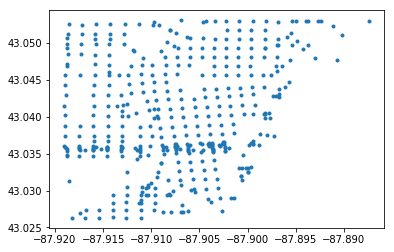

In [21]:
fig = plt.figure()
ax = fig.add_subplot()
x = df_downtown['long']
y = df_downtown['lat']
plt.plot(x, y, marker = '.', ls = 'None')

In [22]:
df_downtown.head()

,img_id,lat,long,date
99,1009,43.035889,-87.917520,2018-10
111,1010,43.035882,-87.916000,2018-10
120,1011,43.035929,-87.918998,2018-10
392,1036,43.043028,-87.896750,2017-08
403,1037,43.043734,-87.896744,2016-11


## Concatenate with the list of images that actually exists with an inner merge

In [26]:
df_downtown_img = df_downtown.merge(df_s3_img, how = 'inner', left_on = 'img_id', right_on = 'imgid')
print(df_downtown_img.shape)
df_downtown_img.head()

(1340, 7)


,img_id,lat,long,date,imgid_heading,imgid,heading
0,10636,43.026961,-87.917439,2018-09,10636_135,10636,135
1,10636,43.026961,-87.917439,2018-09,10636_225,10636,225
2,10636,43.026961,-87.917439,2018-09,10636_315,10636,315
3,10636,43.026961,-87.917439,2018-09,10636_45,10636,45
4,11541,43.027350,-87.915396,2017-10,11541_135,11541,135


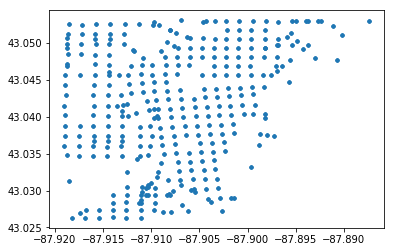

In [27]:
fig = plt.figure()
ax = fig.add_subplot()
x = df_downtown_img['long']
y = df_downtown_img['lat']
plt.plot(x, y, marker = '.', ls = 'None')

In [28]:
df_downtown_img.columns

Index(['img_id', 'lat', 'long', 'date', 'imgid_heading', 'imgid', 'heading'], dtype='object')

In [29]:
df_downtown_img = df_downtown_img[['imgid_heading', 'img_id', 'heading', 'lat', 'long', 'date']]
df_downtown_img.head()

,imgid_heading,img_id,heading,lat,long,date
0,10636_135,10636,135,43.026961,-87.917439,2018-09
1,10636_225,10636,225,43.026961,-87.917439,2018-09
2,10636_315,10636,315,43.026961,-87.917439,2018-09
3,10636_45,10636,45,43.026961,-87.917439,2018-09
4,11541_135,11541,135,43.027350,-87.915396,2017-10


In [30]:
df_downtown_img.to_csv('downtown_imgid_heading_ins3.csv', index = False)